In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/worldgdpbycountry20002020/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3469429.csv
/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv
/kaggle/input/worldpopulationbycountry20002020/API_SP.POP.TOTL_DS2_en_csv_v2_3469297.csv
/kaggle/input/k/lucamassaron/festivities-in-finland-norway-sweden/__results__.html
/kaggle/input/k/lucamassaron/festivities-in-finland-norway-sweden/__notebook__.ipynb
/kaggle/input/k/lucamassaron/festivities-in-finland-norway-sweden/__output__.json
/kaggle/input/k/lucamassaron/festivities-in-finland-norway-sweden/nordic_holidays.csv
/kaggle/input/k/lucamassaron/festivities-in-finland-norway-sweden/custom.css
/kaggle/input/worldpopulationgrowthbycountry20002020/Metadata_Country_API_SP.POP.GROW_DS2_en_csv_v2_3469469.csv
/kaggle/input/worldpopulationgrowthbycountry20002020/API_SP.POP.GROW_DS2_en_csv_v2_3469469-fixed.csv
/kaggle/inpu

In [2]:
import gc
import random
import math

from IPython import display as ipd
from tqdm import tqdm
import dateutil.easter as easter

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold,RepeatedKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import LSTM, Bidirectional, add, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Conv2DTranspose, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, TimeDistributed
from tensorflow.keras.layers import Multiply, Add, Concatenate, Flatten, Average, Lambda

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.constraints import unit_norm, max_norm

from tensorflow.keras import backend as K
from tensorflow_addons.optimizers import CyclicalLearningRate

### Utils

In [3]:
def seeding(SEED, use_tf=False):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    if use_tf:
        tf.random.set_seed(SEED)
    print('seeding done!!!')
    
## https://www.kaggle.com/c/tabular-playground-series-jan-2022/discussion/298201
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)    

### Data Load

In [4]:
RANDOM_SEED = 42
DEBUG = True

seeding(RANDOM_SEED)

train = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/test.csv')
submission = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv')

seeding done!!!


In [5]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


### Adding holidays info from notebook: festivities-in-finland-norway-sweden

https://www.kaggle.com/lucamassaron/festivities-in-finland-norway-sweden

###  Easter dates idea is from notebook:

https://www.kaggle.com/ambrosm/tpsjan22-01-eda-which-makes-sense#Easter

In [6]:
import dateutil.easter as easter

holidays = pd.read_csv('../input/k/lucamassaron/festivities-in-finland-norway-sweden/nordic_holidays.csv')
holidays.date = pd.to_datetime(holidays.date)

easter_dates = []
years = [2015,2016,2017,2018,2019,2020]
for year in years:
     easter_dates.append(easter.easter(year))

def add_holidays( df, holidays, easter_dates ):
    df['holiday'] = 0
    df['easter'] = 0
    countries = ['Finland', 'Norway', 'Sweden']
    for country in countries:
        df.loc[ (df.date.isin(holidays.date)) & (df.country.isin(holidays.country)), 'holiday'] = 1

    df.loc[ (df.date.isin(easter_dates)), 'easter'] = 1
    return df
    
train = add_holidays( train, holidays, easter_dates )
test = add_holidays( test, holidays, easter_dates )

### Very simple date-based FE

sin and cos addition is from notebook by Ambros M:

https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model

In [7]:
def process_dates(df):
    df.date = pd.to_datetime(df.date)
    df['year'] = df.date.dt.year    
    df['month'] = df.date.dt.month
    df['week'] = df.date.dt.week
    df['wd4'] = df.date.dt.dayofweek == 4
    df['wd56'] = df.date.dt.dayofweek >= 5    
    df['wd4'] = df['wd4'].astype(int)
    df['wd56'] = df['wd56'].astype(int)
    df['day'] = df.date.dt.day    

    for k in [1, 2, 3, 12]:
        df[f'sin{k}'] = np.sin(df.date.dt.dayofyear / 365 * 2 * math.pi * k)
        df[f'cos{k}'] = np.cos(df.date.dt.dayofyear / 365 * 2 * math.pi * k)    

    return df

train = process_dates(train)
test = process_dates(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [8]:
#print(f'Train unique days: {train.day.unique().size}, test: {test.day.unique().size}')
print(f'Train unique weeks: {train.week.unique().size}, test: {test.week.unique().size}')
#print(f'Train unique dayofweeks: {train.dayofweek.unique().size}, test: {train.dayofweek.unique().size}')
print(f'Train unique months: {train.month.unique().size}, test: {train.month.unique().size}')
#print(f'Train unique dayofyear: {train.dayofyear.unique().size}, test: {train.dayofyear.unique().size}')

Train unique weeks: 53, test: 52
Train unique months: 12, test: 12


### Adding GDP and population growth data

datasets: https://www.kaggle.com/vladlee/datasets

In [9]:
gdp_growth = pd.read_csv('../input/worldgdpgrowthbycountry20002020/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_3469438-fixed.csv')
gdp_growth = gdp_growth[ gdp_growth['Country Name'].isin(['Sweden', 'Norway', 'Finland'])]
gdp_growth.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
gdp_growth = gdp_growth.T
gdp_growth.columns = ['Finland', 'Norway', 'Sweden']
gdp_growth.index = gdp_growth.index.astype(int)

pop_growth = pd.read_csv('../input/worldpopulationgrowthbycountry20002020/API_SP.POP.GROW_DS2_en_csv_v2_3469469-fixed.csv')
pop_growth = pop_growth[ pop_growth['Country Name'].isin(['Sweden', 'Norway', 'Finland'])]
pop_growth.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1, inplace=True)
pop_growth = pop_growth.T
pop_growth.columns = ['Finland', 'Norway', 'Sweden']
pop_growth.index = pop_growth.index.astype(int)

gdp = pd.read_csv('../input/worldgdpbycountry20002020/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_3469429.csv')
gdp = gdp[ gdp['Country Name'].isin(['Sweden', 'Norway', 'Finland'])]
gdp.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 65'], axis=1, inplace=True)
gdp = gdp.T
gdp.columns = ['Finland', 'Norway', 'Sweden']
gdp.index = gdp.index.astype(int)

pop = pd.read_csv('../input/worldpopulationbycountry20002020/API_SP.POP.TOTL_DS2_en_csv_v2_3469297.csv')
pop = pop[ pop['Country Name'].isin(['Sweden', 'Norway', 'Finland'])]
pop.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 65'], axis=1, inplace=True)
pop = pop.T
pop.columns = ['Finland', 'Norway', 'Sweden']
pop.index = pop.index.astype(int)

In [10]:
def add_growth_features(df, gdp, pop, gdp_growth, pop_growth):
    years = [2015,2016,2017,2018,2019,2020]
    df['gdp_per_capita'] = 0
    df['gdp_growth'] = 0
    df['pop_growth'] = 0
    for column in gdp.columns:
        for year in years:
            df.loc[ (df.year == year) & (df.country == column), 'gdp_per_capita'] = gdp[column][year]/pop[column][year]
            df.loc[ (df.year == year) & (df.country == column), 'gdp_growth'] = gdp_growth[column][year]
            df.loc[ (df.year == year) & (df.country == column), 'pop_growth'] = pop_growth[column][year]
    
    df['gdp_per_capita'] = RobustScaler().fit_transform(df['gdp_per_capita'].values.reshape(-1, 1))
    return df

train = add_growth_features(train, gdp, pop, gdp_growth, pop_growth)
test = add_growth_features(test, gdp, pop, gdp_growth, pop_growth)

## Adding AmbrosM more features function from:

https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model#Simple-feature-engineering-(without-holidays)

(fixed for Keras)
witout thi

In [11]:
# Feature engineering for holidays
def engineer_more(df):
    """Return a new dataframe with more engineered features"""

    # End of year
    new_df = pd.concat([df,
                        pd.DataFrame({f"dec{d}":
                                      ((df.date.dt.month == 12) & (df.date.dt.day == d)).astype(int)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      ((df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')).astype(int)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      ((df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')).astype(int)
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"jan{d}":
                                      ((df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')).astype(int)
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      ((df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')).astype(int)
                                      for d in range(1, 15)})],
                       axis=1)
    
    # May
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      ((df.date.dt.month == 5) & (df.date.dt.day == d)).astype(int) 
                                      for d in list(range(1, 10))}), #  + list(range(17, 25))
                        pd.DataFrame({f"may{d}":
                                      ((df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')).astype(int)
                                      for d in list(range(19, 26))})],
                       axis=1)
    
    # June and July
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      ((df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')).astype(int)
                                      for d in list(range(8, 14))}),
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      ((df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')).astype(int)
                                      for d in list(range(-4, 6))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      ((df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')).astype(int)
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      ((df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')).astype(int)
                                      for d in list(range(6, 14))})],
                       axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      ((df.date - easter_date == np.timedelta64(d, "D"))).astype(int)
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})],
                       axis=1)
    
    return new_df

train = engineer_more(train)
test = engineer_more(test)

In [12]:
target = train.num_sold
target_sqrt = np.sqrt(train.num_sold)
train.drop(['row_id','num_sold','date', 'year', 'day'], axis=1, inplace=True)
test.drop(['row_id', 'date', 'year', 'day'], axis=1, inplace=True)

In [13]:
features = list(test.columns)
print(list(features))

['country', 'store', 'product', 'holiday', 'easter', 'month', 'week', 'wd4', 'wd56', 'sin1', 'cos1', 'sin2', 'cos2', 'sin3', 'cos3', 'sin12', 'cos12', 'gdp_per_capita', 'gdp_growth', 'pop_growth', 'dec24', 'dec25', 'dec26', 'dec27', 'dec28', 'dec29', 'dec30', 'dec31', 'n-dec24', 'n-dec25', 'n-dec26', 'n-dec27', 'n-dec28', 'n-dec29', 'n-dec30', 'n-dec31', 'f-jan1', 'f-jan2', 'f-jan3', 'f-jan4', 'f-jan5', 'f-jan6', 'f-jan7', 'f-jan8', 'f-jan9', 'f-jan10', 'f-jan11', 'f-jan12', 'f-jan13', 'jan1', 'jan2', 'jan3', 'jan4', 'jan5', 'jan6', 'jan7', 'jan8', 'jan9', 's-jan1', 's-jan2', 's-jan3', 's-jan4', 's-jan5', 's-jan6', 's-jan7', 's-jan8', 's-jan9', 's-jan10', 's-jan11', 's-jan12', 's-jan13', 's-jan14', 'may1', 'may2', 'may3', 'may4', 'may5', 'may6', 'may7', 'may8', 'may9', 'may19', 'may20', 'may21', 'may22', 'may23', 'may24', 'may25', 'june8', 'june9', 'june10', 'june11', 'june12', 'june13', 'wed_june-4', 'wed_june-3', 'wed_june-2', 'wed_june-1', 'wed_june0', 'wed_june1', 'wed_june2', 'wed

### Encode category columns 

In [14]:
country_encoder = LabelEncoder()
train['country_enc'] = country_encoder.fit_transform(train['country'])
test['country_enc'] = country_encoder.transform(test['country'])

store_encoder = LabelEncoder()
train['store_enc'] = store_encoder.fit_transform(train['store'])
test['store_enc'] = store_encoder.transform(test['store'])

product_encoder = LabelEncoder()
train['product_enc'] = product_encoder.fit_transform(train['product'])
test['product_enc'] = product_encoder.transform(test['product'])


train.drop(['country','store','product'], axis=1, inplace=True)
test.drop(['country','store','product'], axis=1, inplace=True)

In [15]:
scaler = RobustScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test_scaled = scaler.fit_transform(test)

In [16]:
trainX = train.values.reshape(-1, train_scaled.shape[1], 1)
testX = test.values.reshape(-1, test_scaled.shape[1], 1)

print(f'Original sizes: train: {trainX.shape}, y_train: {target.shape}' )

Original sizes: train: (26298, 151, 1), y_train: (26298,)


### Model and train

In [17]:
def create_model( units, X, optimizer=Adam()):
    model = Sequential([
        Input(shape=(1, X.shape[1]), dtype='float32'),
        LSTM(units*4, return_sequences=True, kernel_initializer='glorot_uniform'),
        BatchNormalization(),
        LSTM(units*2, return_sequences=True, kernel_initializer='glorot_uniform'),
        BatchNormalization(),
        LSTM(units, return_sequences=True, kernel_initializer='glorot_uniform'),
        BatchNormalization(),
        LSTM(units*2, return_sequences=True, kernel_initializer='glorot_uniform'),
        BatchNormalization(),
        LSTM(units*4, return_sequences=True, kernel_initializer='glorot_uniform'),
        BatchNormalization(),
        Dense(units, activation='linear'),
        Dense(1),
    ])  
    model.compile(optimizer = optimizer, loss = 'mape')
    return model

In [18]:
UNITS = 32
EPOCHS = 100
BATCH_SIZE = 512
TOTAL_SPLITS = 10
N_REPEATS = 3
LEARNING_RATE = 0.002123

m = create_model(UNITS, trainX, Adam(learning_rate=LEARNING_RATE))
m.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            143360    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64)             256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 32)             128       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 64)             2

In [19]:
%%time

tf.keras.backend.clear_session()
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=7, verbose=1,  min_lr=1e-7)
es = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=40, verbose=1, mode="min", restore_best_weights=True)


scores = []
models = []
histories = []
folds = RepeatedKFold(n_splits=TOTAL_SPLITS, n_repeats=N_REPEATS)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_scaled, target_sqrt)):
    print('-'*15, '>', f'Fold {fold_n+1}', '<', '-'*15)
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = target_sqrt.iloc[train_index], target_sqrt.iloc[valid_index]    
    
    X_train = X_train.values.reshape(len(X_train), 1, X_train.shape[1])
    X_valid = X_valid.values.reshape(len(X_valid), 1, X_valid.shape[1])
    
    checkpoint_path = f'model_{fold_n}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    callbacks = [es, checkpoint, lr]    
    
    model = create_model(UNITS, train, Adam(learning_rate=LEARNING_RATE))
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = BATCH_SIZE, epochs = EPOCHS, 
                    verbose=0, shuffle=True, callbacks=callbacks)
    
    model.load_weights(checkpoint_path)
    
    oof_pred = model.predict(X_valid).reshape(-1)
    oof_score = SMAPE(y_valid, oof_pred)
    print(f'OOF SMAPE: {oof_score}')
    
    scores.append(oof_score)
    models.append(model)
    histories.append(history)

--------------- > Fold 1 < ---------------


2022-01-24 20:08:00.882912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0006369000300765037.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.00019107000553049146.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 5.732100253226235e-05.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.7196300541399977e-05.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 5.158890053280629e-06.

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.5476669886993476e-06.
OOF SMAPE: 2.16961198056301
--------------- > Fold 2 < ---------------

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0006369000300765037.

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00019107000553049146.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 5.732100253226235e-05.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1.7196300541399977e-05.

Epoch 00069: ReduceLROnPlateau reducing learning rate to 5.158890053280629e-06.

Epoch 00081: ReduceLROnPlateau r

In [20]:
print(f'OOF SMAPE: { np.mean(scores)}')

OOF SMAPE: 2.184021418640802


### Plot metrics

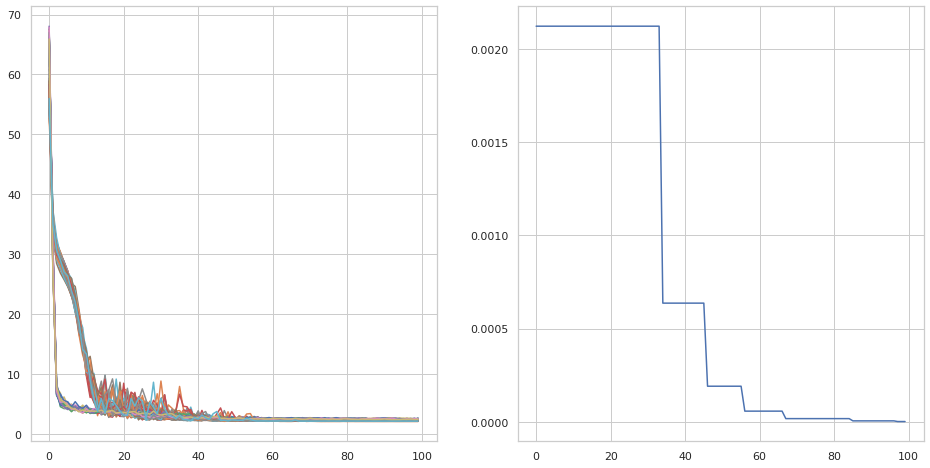

In [21]:
xx = range(0, EPOCHS)
col_metrics = ["loss", "val_loss", "lr"]

f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
for hist in histories:
    df = pd.DataFrame(hist.history, columns=col_metrics)
    ax1.plot( df[[col_metrics[0], col_metrics[1]]])
ax2.plot( df[[col_metrics[2]]])

plt.show()

In [22]:
## average predictions over all models

testX = test.values.reshape(len(test), 1, test.shape[1])
y_pred = np.zeros(len(testX))
for model in models:
    y_pred += model.predict(testX).reshape(-1)

y_pred = y_pred / len(models)

In [23]:
submission['num_sold'] = np.round(y_pred**2).astype(int)
submission.to_csv('submission.csv', index=False, float_format='%.6f')
submission.head(20)

,row_id,num_sold
0,26298,393
1,26299,612
2,26300,173
3,26301,690
4,26302,1037
5,26303,317
6,26304,568
7,26305,914
8,26306,261
9,26307,1024
